In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv")

In [3]:
df = df.drop(columns=['DoctorInCharge'], axis=1)
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [4]:
X = df.drop(['Diagnosis', 'PatientID'], axis=1).values
y = df['Diagnosis'].values

In [5]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
pca = PCA(12)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [9]:
rf_model = RandomForestClassifier()
params = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 1000],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'max_samples': [None, 0.5, 0.75, 1.0]}
rf_random_search = RandomizedSearchCV(rf_model,
                                   param_distributions=params,
                                   n_iter=50,
                                   scoring='roc_auc',
                                   cv=5,
                                   verbose=3,
                                   random_state=42,
                                   n_jobs=-1)
rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 2/5] END criterion=entropy, max_features=log2, max_leaf_nodes=None, max_samples=None, min_samples_leaf=8, min_samples_split=15, min_weight_fraction_leaf=0.4, n_estimators=400;, score=0.775 total time=   1.7s
[CV 1/5] END criterion=entropy, max_features=log2, max_leaf_nodes=50, max_samples=None, min_samples_leaf=6, min_samples_split=5, min_weight_fraction_leaf=0.5, n_estimators=50;, score=0.500 total time=   0.2s
[CV 4/5] END criterion=entropy, max_features=log2, max_leaf_nodes=50, max_samples=None, min_samples_leaf=6, min_samples_split=5, min_weight_fraction_leaf=0.5, n_estimators=50;, score=0.500 total time=   0.2s
[CV 2/5] END criterion=entropy, max_features=log2, max_leaf_nodes=20, max_samples=None, min_samples_leaf=8, min_samples_split=5, min_weight_fraction_leaf=0.1, n_estimators=300;, score=0.830 total time=   1.7s
[CV 1/5] END criterion=log_loss, max_features=None, max_leaf_nodes=30, max_samples=0.5, min_samples_l

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50],
                                        'max_samples': [None, 0.5, 0.75, 1.0],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'min_weight_fraction_leaf': [0.0, 0.1,
                                                                     0.2, 0.3,
                                                                     0.4, 0.5],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500, 1000]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [10]:
best_param = rf_random_search.best_params_
rf_tuned = RandomForestClassifier(**best_param)
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.772093023255814
Confusion Matrix:
[[250  27]
 [ 71  82]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       277
           1       0.75      0.54      0.63       153

    accuracy                           0.77       430
   macro avg       0.77      0.72      0.73       430
weighted avg       0.77      0.77      0.76       430



In [11]:
import tensorflow as tf

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X Train :{X_train.shape}")
print(f"X Test :{X_test.shape}")
print(f"y Train :{y_train.shape}")
print(f"y Test :{y_test.shape}")



X Train :(1719, 32)
X Test :(430, 32)
y Train :(1719,)
y Test :(430,)


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 634,625 (2.42 MB)

 Trainable params: 634,625 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              restore_best_weights=True)

In [17]:
hist = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_test, y_test),
    # callbacks = [early_stop],
    epochs = 100,
    batch_size = 64)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5344 - loss: 3.5645 - val_accuracy: 0.6442 - val_loss: 0.7662
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6060 - loss: 0.7545 - val_accuracy: 0.6442 - val_loss: 0.6608
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5925 - loss: 0.6837 - val_accuracy: 0.6442 - val_loss: 0.6548
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6094 - loss: 0.6774 - val_accuracy: 0.6442 - val_loss: 0.6540
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6388 - loss: 0.6614 - val_accuracy: 0.6442 - val_loss: 0.6486
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6309 - loss: 0.6601 - val_accuracy: 0.6442 - val_loss: 0.6506
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6466 - loss: 0.6528 - val_accuracy: 0.6442 - val_loss: 0.6508
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6438 - loss: 0.6526 - val_accuracy: 0.

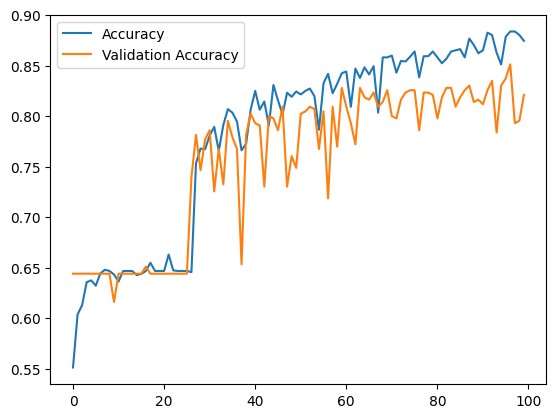

In [18]:
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

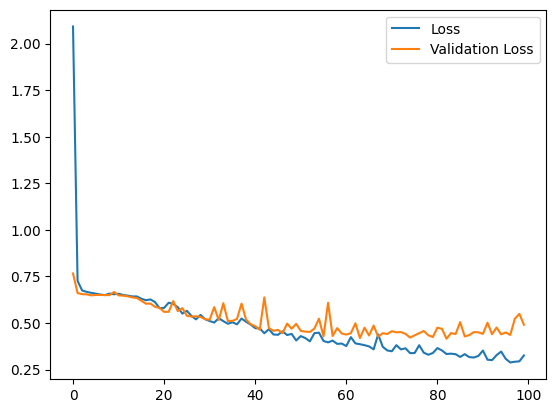

In [19]:
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()

In [21]:

y_pred_prob = model.predict(X_test)
y_pred = np.round(y_pred_prob).astype(int)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8300 - loss: 0.4418 
Accuracy: 82.09%
Confusion Matrix:
[[245  32]
 [ 45 108]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       277
           1       0.77      0.71      0.74       153

    accuracy                           0.82       430
   macro avg       0.81      0.80      0.80       430
weighted avg       0.82      0.82      0.82       430

[CV 3/5] END criterion=gini, max_features=None, max_leaf_nodes=10, max_samples=0.5, min_samples_leaf=6, min_samples_split=2, min_weight_fraction_leaf=0.3, n_estimators=400;, score=0.813 total time=   2.0s
[CV 3/5] END criterion=gini, max_features=log2, max_leaf_nodes=None, max_samples=0.5, min_samples_leaf=1, min_samples_split=5, min_weight_fraction_leaf=0.1, n_estimators=200;, score=0.858 total time=   0.9s
[CV 1/5] END criterion=gini, max_features=sqrt, max_leaf_nodes=None